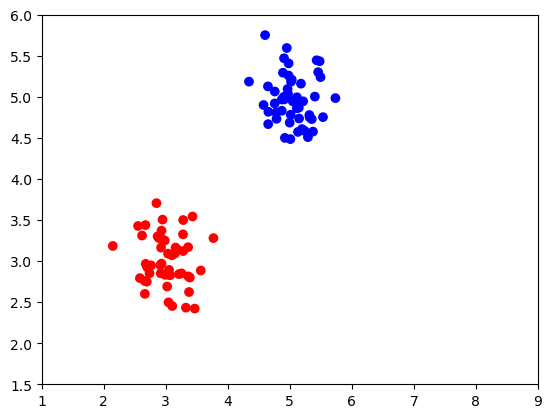

In [1]:
"""
2. Generate data
"""
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import linalg

# generate data(number = 50)
N1 = 50
N2 = 50
K = 2
sigma = 0.1

mean = (3, 3)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)  #(50, 2)
c1 = ['red'] * len(X1)

mean = (5, 5)
cov = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len(X2)

X = np.concatenate((X1, X2))
color = np.concatenate((c1, c2))

# red: label 1, C1; blue: label 0, C2
T = 0 * np.ones((len(X), K))
for n in range(0, len(X)):
    if n < len(X1):
        T[n][0] = 1
    if N1 <= n < len(X1) + len(X2):
        T[n][1] = 1
T = T.astype(int)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
plt.xlim(1, 9)
plt.ylim(1.5, 6.0)
plt.show()

In [2]:
"""
3. Predictive distribution and probability map.
"""


# Basis fubction for classification
def basis_function(x, M, d, s, N):
    fai = np.zeros((N, M))
    mu = [0] * M
    for m in range(1, M):
        mu[m] += d * m

    for n in range(N):
        for m in range(M):
            fai[n][m] = math.exp(((x[n][0] - mu[m]) ** 2 + (x[n][1] - mu[m]) ** 2) / (2 * s ** 2))

    return fai


# compute delta_E
def compute_delta_E(w, fai, a, M, T):
    t = np.dot(w.T, fai.T).T
    theta = 1.0 / (1 + np.exp(-t))
    SS = a * np.identity(M)
    m0 = np.zeros((M, 1))
    delta_E = linalg.inv(SS) @ (w - m0) + fai.T @ (theta - T)
    return delta_E


# compute matrix H
def compute_H(fai, M, a, w, N):
    SS = a * np.identity(M)
    R = np.zeros((N, N))
    for n in range(N):
        temp = fai[n].reshape(M, 1)
        t = np.dot(w.T, temp)
        theta = 1.0 / (1 + math.exp(-t))
        R[n][n] = theta * (1 - theta)

    H = linalg.inv(SS) + fai.T @ R @ fai
    return H


def newtonMethod(assume, fai, a, M, T, N):
    w = assume
    Next = np.zeros((M, 1))
    A = compute_delta_E(w, fai, a, M, T)
    B = compute_H(fai, M, a, w, N)

    if np.any(A == 0):
        return w
    else:
        Next = w - linalg.inv(B) @ A

    temp = np.abs(A - compute_delta_E(Next, fai, a, M, T))
    if not np.any(A > 1e-6):
        return Next
    else:
        return newtonMethod(Next, fai, a, M, T, N)


#========================
# set parameters
M = 3  # M=3
d = 2.0
s = 5.0
a = 0.5
N = len(X)
fai = basis_function(X, M, d, s, N)
assume = np.zeros((M, 1))
T1 = T[:, 0].reshape(N, 1)
# E = compute_delta_E(w, fai, a, M, T1)
# H = compute_H(fai, M, a, w, N)
w = newtonMethod(assume, fai, a, M, T1, N)
print('Meet delta_E = 0, w = ' + str(w))
yn = w.T @ fai.T
Tn = 1.0 / (1 + np.exp(-yn))
Tn = Tn.reshape(1, N)  # for convenience, set Tn 1*N 
Tn[Tn > 0.5] = 1
Tn[Tn < 0.5] = 0  # use characteristic of sigmoid function to do classification

Meet delta_E = 0, w = [[-2.09142915]
 [ 0.96114615]
 [ 2.75984102]]


/var/folders/zv/7_nb_lnx5llfxwncr2x_6tvh0000gn/T/ipykernel_48283/3573965666.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('rainbow')


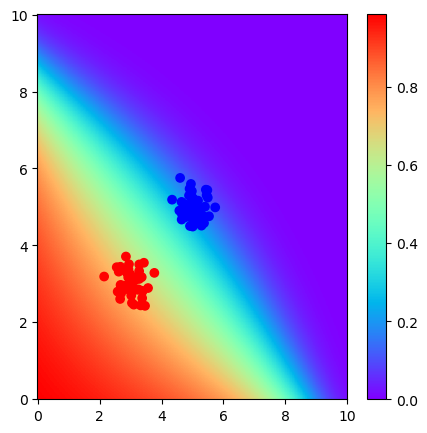

In [3]:
# plot probabiliy map
NN = 500  # number of samples
x1_min, x2_min = 0, 0
x1_max, x2_max = 10, 10
t1 = np.linspace(x1_min, x1_max, NN)
t2 = np.linspace(x2_min, x2_max, NN)
x1, x2 = np.meshgrid(t1, t2)  # generate mesh
x_show = np.stack((x1.flat, x2.flat), axis=1)  # 2-axis points

# compute Tn for grid ponts using w above
fai_pred = basis_function(x_show, M, d, s, NN ** 2)
yn_pred = w.T @ fai_pred.T
Tn_pred = 1.0 / (1 + np.exp(-yn_pred))
Tn_pred = Tn_pred.reshape(1, NN ** 2)

fig, ax = plt.subplots(figsize=(5, 5))
cm = plt.cm.get_cmap('rainbow')
c = ax.pcolormesh(x1, x2, Tn_pred.reshape(x1.shape), cmap=cm)
fig.colorbar(c, ax=ax)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
plt.show()

In [4]:
"""
4.Ask the user to enter any new value of x, and your task is to provide the decision whether it belongs to C1 or C2, and its uncertainty 
information. 
"""


# compute fai for one sample
def basis_function_1(x, M, d, s):
    fai = np.zeros((1, M))
    mu = [0] * M
    for m in range(1, M):
        mu[m] += d * m

    for m in range(M):
        fai[:, m] = math.exp(((x[0] - mu[m]) ** 2 + (x[1] - mu[m]) ** 2) / (2 * s ** 2))

    return fai


# compute uncertainty informationp(tnew|t)
def uncertainty_info(w, fai_1, SSn):
    aMAP = w.T @ fai_1.T
    Sigma = fai_1 @ SSn @ fai_1.T
    p_temp = aMAP * (1 + (math.pi / 8) * Sigma) ** (-0.5)
    p = 1.0 / (1 + math.exp(-p_temp))
    return p


# =================
# set parameters
M = 3  # M = 3
d = 2.0
s = 5.0
a = 0.5
N1 = 1
# ask to enter
x1_t = input("Please enter a new point by x1,x2: ")
x1 = list(map(int, x1_t.split(',')))  # input format:x,y
# comput fai for one sample
fai_1 = basis_function_1(x1, M, d, s)
# do classification(red:1, blue:0)
y_pred = w.T @ fai_1.T
Tn_pred = 1.0 / (1 + math.exp(-y_pred))

# compute SSn = H
SSn_temp = compute_H(fai_1, M, a, w, N1)
SSn = linalg.inv(SSn_temp)
# compute uncertainty information
p = uncertainty_info(w, fai_1, SSn)

# use characteristic of sigmoid function and print results
if Tn_pred > 0.5:
    print(f'classification: C1(red), Label: 1, p(tnew|t) = {p}')
else:
    print(f'classification: C2(blue), Label: 0, p(tnew|t) = {p}')

classification: C1(red), Label: 1, p(tnew|t) = 0.8914346662577396
